In [89]:
%pylab inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import talib
plt.figure(figsize(15,7));
from datetime import datetime
from sklearn.metrics import accuracy_score, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


<Figure size 1080x504 with 0 Axes>

In [2]:
df = pd.read_csv('data/BTCUSDT_2019_1h.csv', sep='\t')
df.head()

,open time,open,high,low,close,volume,number of trades
0,2019-01-01 00:00:00,3701.23,3713.00,3689.88,3700.31,686.4,5534
1,2019-01-01 01:00:00,3700.20,3702.73,3684.22,3689.69,613.5,5086
2,2019-01-01 02:00:00,3689.67,3695.95,3675.04,3690.00,895.3,6391
3,2019-01-01 03:00:00,3690.00,3699.77,3685.78,3693.13,796.7,5709
4,2019-01-01 04:00:00,3692.32,3720.00,3685.94,3692.71,1317.5,7908


In [21]:
def rescale(df, window=4):
    res = pd.DataFrame(columns=['open', 'high', 'low', 'close'])
    res['open'] = df['open'].values[::window]
    res['high'] = df['high'].rolling(window).max().dropna()[::window].values
    res['low'] = df['low'].rolling(window).min().dropna()[::window].values
    res['close'] = df['close'].values[window-1:][::window]
    return res

In [3]:
def candles_view(df, hours):
    #recommended rows: <180
    import matplotlib.patches as patches
    open  = df.open
    high  = df.high
    low   = df.low
    close = df.close
    fig = plt.figure()
    ax = fig.add_subplot(111)
    k = 24/hours

    r_width = 0.8 / k
    periods = range(len(open))
    for timestamp in periods:
        r_height = abs(open[timestamp] - close[timestamp]) + 0.1
        r_x = timestamp/k - r_width/2.0
        r_y = min(open[timestamp], close[timestamp])
        if (open[timestamp] > close[timestamp]):
            ax.add_patch(patches.Rectangle((r_x, r_y), r_width, r_height, facecolor='r'))
            plt.plot([timestamp/k, timestamp/k], [low[timestamp], high[timestamp]], 'r')
        else:
            ax.add_patch(patches.Rectangle((r_x, r_y), r_width, r_height, facecolor='g'))
            plt.plot([timestamp/k, timestamp/k], [low[timestamp], high[timestamp]], 'g')

    #mng = plt.get_current_fig_manager()
    #mng.resize(*mng.window.maxsize())
    plt.show()

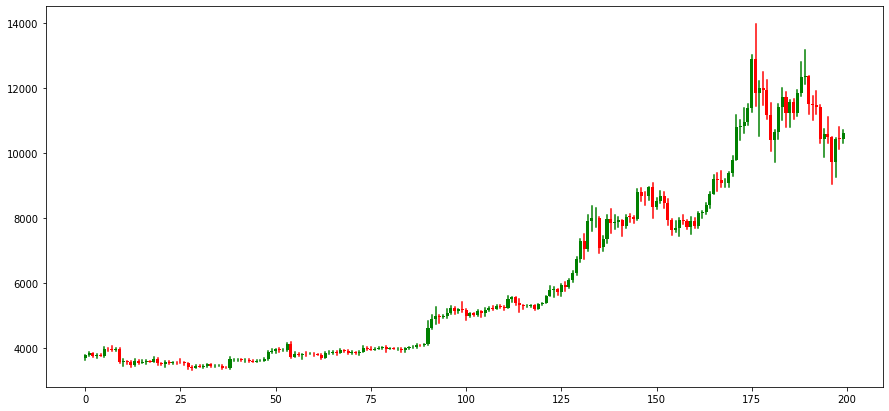

In [35]:
candles_view(rescale(df[df.index<24*200], window=24), hours=24)

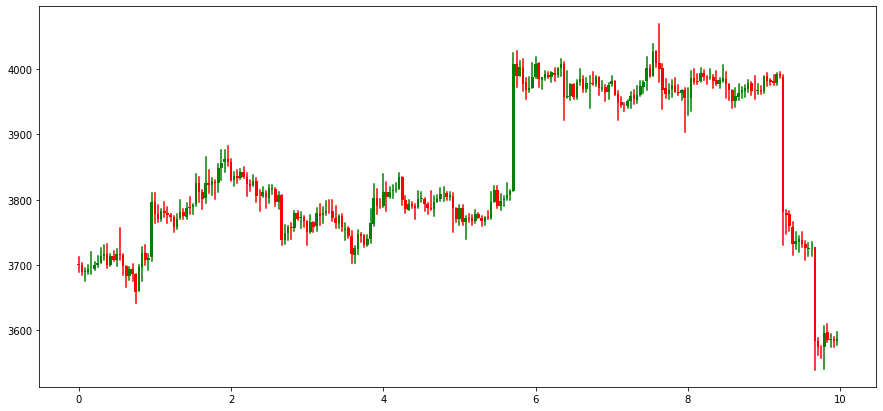

In [36]:
candles_view(df2, hours=1)

In [46]:
a = df[['open', 'volume', 'number of trades']].rename(columns={'open':'price'})
a.shape

(8733, 3)

In [67]:
a['ema_7'] = talib.MA(a.price, 2)
a['ema_28'] = talib.MA(a.price, 2)
a['ema_50'] = talib.MA(a.price, 2)
a['rsi_7'] = talib.RSI(a.price, 7)
a['rsi_28'] = talib.RSI(a.price, 28)
a['mom_7'] = talib.MOM(a.price, 7)
a['mom_28'] = talib.MOM(a.price, 28)

In [72]:
a = a[a.index>28]

In [81]:
features = a.columns[3:-2]
features

Index(['ma_2', 'rsi_7', 'rsi_28', 'ema_7', 'ema_28', 'ema_50', 'mom_7',
       'mom_28'],
      dtype='object')

In [83]:
trn = a[a.index<7000]
tst = a[a.index>=7000]

In [80]:
a['target_price'] = a.price.shift(-1)
a['target'] = (a['target_price'] > a['price']).astype(int)
a.head()

,price,volume,number of trades,ma_2,rsi_7,rsi_28,ema_7,ema_28,ema_50,mom_7,mom_28,target,target_price
29,3776.16,415.8,5001,3778.080,64.716427,60.151666,3778.080,3778.080,3778.080,68.18,75.96,0,3773.04
30,3773.04,917.0,6808,3774.600,62.622088,59.608680,3774.600,3774.600,3774.600,60.19,83.37,0,3758.53
31,3758.53,1338.8,9727,3765.785,53.268788,57.121823,3765.785,3765.785,3765.785,-37.92,68.53,1,3772.64
32,3772.64,2216.6,14534,3765.585,60.040037,58.852969,3765.585,3765.585,3765.585,-5.98,80.32,1,3780.81
33,3780.81,1483.6,8460,3776.725,63.602685,59.826886,3776.725,3776.725,3776.725,10.83,86.83,0,3773.84


In [84]:
lgbm_params = {
    'colsample_bytree': 0.4,
    'lambda_l1': 2.5,
    'lambda_l2': 7.5,
    'bagging_fraction': 0.5,
    'learning_rate': 0.2,
    'num_leaves': 4,
    'max_bin': 128,
    'n_estimators': 50,
}
model = lgb.LGBMClassifier(**lgbm_params)

In [86]:
model.fit(trn[features], trn['target']);

In [92]:
print(roc_auc_score(trn['target'], model.predict_proba(trn[features])[:, 1]))
print(roc_auc_score(tst['target'], model.predict_proba(tst[features])[:, 1]))

0.6073921739020047
0.564153534288028


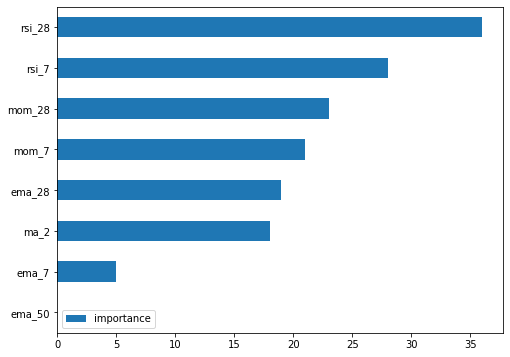

In [97]:
importances = model.feature_importances_
tmp = pd.DataFrame(data={'importance':importances}, index=features).sort_values(by='importance', ascending=True)
tmp.plot(kind='barh', figsize=(8,6));

In [48]:
a.head()

,price,volume,number of trades,ma_2,rsi_7,rsi_28
0,3701.23,686.4,5534,NaN,NaN,NaN
1,3700.20,613.5,5086,3700.715,NaN,NaN
2,3689.67,895.3,6391,3694.935,NaN,NaN
3,3690.00,796.7,5709,3689.835,NaN,NaN
4,3692.32,1317.5,7908,3691.160,NaN,NaN


In [42]:
talib.get_function_groups()

{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C